In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
import ast
import csv
import itertools
from itertools import product
import numpy as np
import random
import ast
import pandas as pd
import itertools
from itertools import product
import csv
from src.data_preprocessing import *
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import *
from src.utils import *
# from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
from loss_functions import *
from src.neural_network import *
from src.train_and_evaluate import *
from src.random_search import *
from src.k_fold_cross_validation import *
from src.early_stopping import *
# from src.ensemble_learning import *
# from src.data_split import *
# from src.model import *
np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [20]:
MONK_NUM=1
X_train, y_train = load_data(MONK_NUM=MONK_NUM)
X_test, y_test = load_data(MONK_NUM=MONK_NUM, train=False)

one hot encoded data:  (124, 17)
one hot encoded data:  (432, 17)


In [21]:
from sklearn.model_selection import train_test_split  # Ensure this import is present

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [22]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 99
Validation set size: 25


In [23]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (99, 17)
the shape:  (25, 17)
the shape:  (99, 1)
the shape:  (25, 1)


In [48]:
param_distributions = {
    'learning_rate': [1e-1, 3e-2, 7e-3],
    'l1': [1e-6, 1e-3, 1e-4],
    'l2': [1e-2, 1e-5, 1e-3],
    'dropout_rate': [0.3, 0.1, 0.0],
    'batch_size': [8, 32, 1000],
    'n_epochs': [150, 300],
    'hidden_size': [4, 6],
    'hidden_activation': [Activation_Sigmoid, Activation_ReLU, Activation_Leaky_ReLU,  Activation_Tanh],
    'batch_norm': [False, True],
    'weight_decay': [0, 1e-2, 2e-2],
    'n_h_layers': [1, 2, 3],
    'patience': [30, 50],
    'CC': [False],
    'weights_init': ['gaussian', 'gaussian_scaled', 'xavier', 'he', 'random'],
    'output_activation': [Activation_Sigmoid()],
    'sched_decay': [1]
}

print(f"Number of possible combinations: {count_permutations(param_distributions)}")

Number of possible combinations: 699840


In [49]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=5, csv_path=f"monk{MONK_NUM}_top5res.csv")  # adjust n_iters as needed

print(best_hyperparams)

Iteration 0
✅ Fold 1/5 | Validation Accuracy: 0.4000
✅ Fold 2/5 | Validation Accuracy: 0.8000
✅ Fold 3/5 | Validation Accuracy: 0.4000
✅ Fold 4/5 | Validation Accuracy: 0.3500
✅ Fold 5/5 | Validation Accuracy: 0.5263
📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.4953

Iteration 1
✅ Fold 1/5 | Validation Accuracy: 0.4000
✅ Fold 2/5 | Validation Accuracy: 0.4500
✅ Fold 3/5 | Validation Accuracy: 0.9000
✅ Fold 4/5 | Validation Accuracy: 0.3500
✅ Fold 5/5 | Validation Accuracy: 0.4737
📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.5147

Iteration 2
✅ Fold 1/5 | Validation Accuracy: 0.7000
✅ Fold 2/5 | Validation Accuracy: 0.6500
✅ Fold 3/5 | Validation Accuracy: 0.8500
✅ Fold 4/5 | Validation Accuracy: 0.7000
✅ Fold 5/5 | Validation Accuracy: 0.7895
📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.7379

Iteration 3
✅ Fold 1/5 | Validation Accuracy: 0.8500
✅ Fold 2/5 | Validation Accuracy: 0.9000
✅ Fold 3/5 | Validation Accuracy: 0.9000
✅ Fold 4/5 | Valida

In [50]:
print(best_hyperparams)

{'learning_rate': 0.1, 'l1': 1e-06, 'l2': 0.001, 'dropout_rate': 0.0, 'batch_size': 1000, 'n_epochs': 150, 'hidden_size': 4, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': False, 'weight_decay': 0.02, 'n_h_layers': 1, 'patience': 50, 'CC': False, 'weights_init': 'xavier', 'output_activation': <src.activation_functions.Activation_Sigmoid object at 0x7f44c6900680>, 'sched_decay': 1, 'val_accuracy': np.float64(0.858421052631579)}


GRID SEARCH

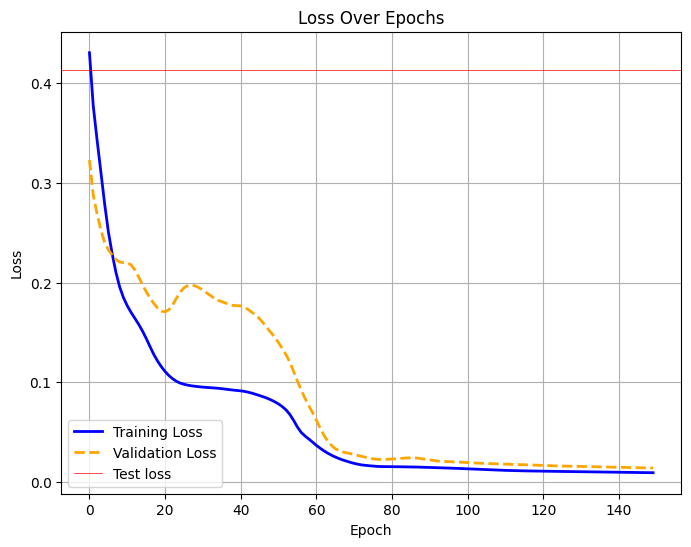

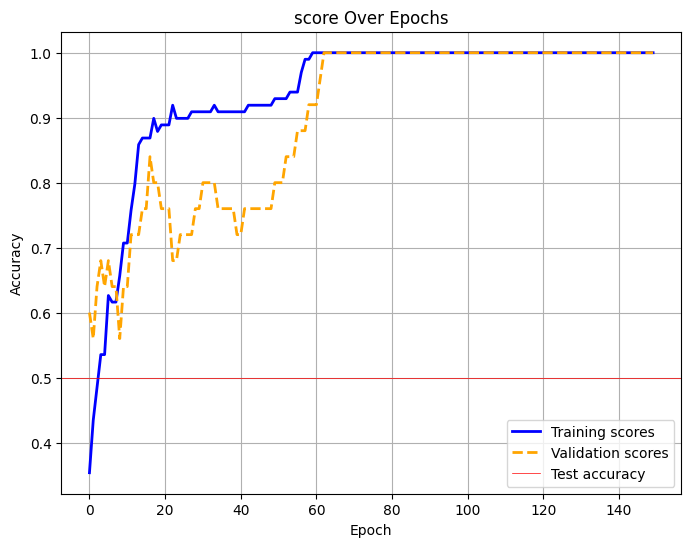

In [51]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers']
    )

train = Train(best_hyperparams, model)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_test, y_test)
train.plot(score=True)

In [52]:
print(train.train_losses, train.val_losses)

[np.float64(0.43071644359508715), np.float64(0.37739850649739287), np.float64(0.343542914307664), np.float64(0.3116928974432379), np.float64(0.27942350059642235), np.float64(0.25091755722465403), np.float64(0.22903557579289407), np.float64(0.21017072838510403), np.float64(0.19542512342908797), np.float64(0.18478254853506418), np.float64(0.17667580612522896), np.float64(0.17006789421114402), np.float64(0.16422075363628183), np.float64(0.15819719668219212), np.float64(0.1514868044893752), np.float64(0.14395552421061045), np.float64(0.13582116187581733), np.float64(0.127954137344478), np.float64(0.12125373184509905), np.float64(0.11558155333145333), np.float64(0.11067392854165391), np.float64(0.10666485980351395), np.float64(0.10344265166958468), np.float64(0.10088671084976991), np.float64(0.09908501864807058), np.float64(0.09789843048908774), np.float64(0.09701754149082267), np.float64(0.09635181529623822), np.float64(0.09587466250636392), np.float64(0.09543856555464546), np.float64(0.09

In [53]:
print(f"Test Accuracy: {train.test_score:.4f}")

Test Accuracy: 0.5000


In [54]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_size=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hyperparams['hidden_activation'],
                dropout_rate=hyperparams['dropout_rate'],
                use_batch_norm=hyperparams['batch_norm'],
                n_h_layers=hyperparams['n_h_layers']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

Training model 1/5
Model 1 validation accuracy: 1.0000
Training model 2/5
Model 2 validation accuracy: 1.0000
Training model 3/5
Model 3 validation accuracy: 1.0000
Training model 4/5
Model 4 validation accuracy: 1.0000
Training model 5/5
Model 5 validation accuracy: 1.0000
Ensemble Test Accuracy: 0.5000


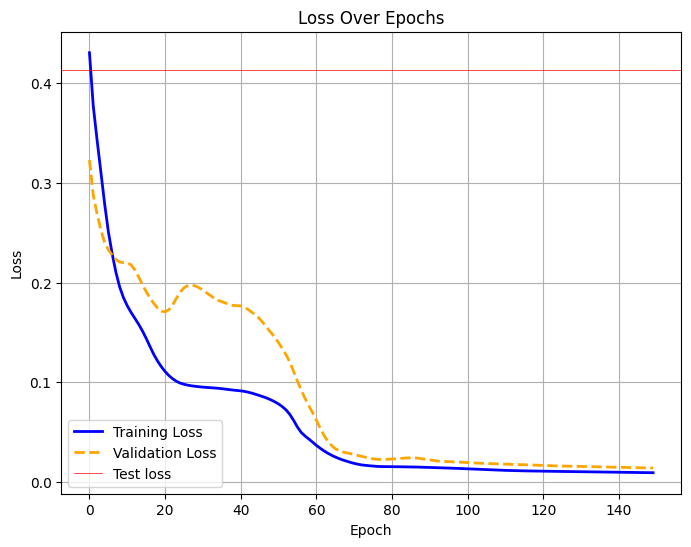

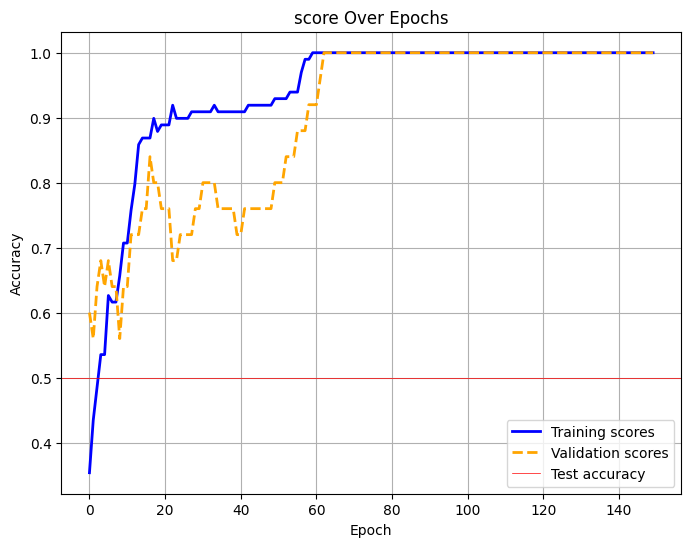

In [55]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(score=True)